In [1]:
import numpy as np
import pandas as pd
from scipy import stats 
import typing
import tqdm
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
datos=pd.read_csv('Datos\CarPrice_Assignment.csv',index_col=0)
datos.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
datos.isna().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [4]:
datos.corr().style.background_gradient(cmap='coolwarm')

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,-0.178515,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984


In [5]:
escalador=MinMaxScaler()

In [6]:
y=np.array(datos['price'])
x=datos.drop(['price'],axis=1)
x=x.loc[:,['symboling','wheelbase','carlength','carwidth','carheight',	'curbweight','enginesize','boreratio','horsepower','peakrpm','citympg','highwaympg']]
X=escalador.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [7]:
class Ridge:
    coef: float
    #valor alpha para la penalización l2
    def __init__(self,alpha):
        self.alpha=float(alpha)
    
    #para esimar los coeficientes de acuerdo a la función de perdida
    def gradient(self,x,y,coef):
        err=y-np.dot(x,coef)#error de pronostico (y-y^)
        return -2*err*x #mutiplica el 2*error por cada vector de x 
    
    def det_coef(self,coef,dxi_loss,learning_rate):
        coef-=dxi_loss[0]*np.array([learning_rate])
        reg=(2*np.array([self.alpha]))*coef#penalizacion al gradiente
        coef+=reg
        return coef
    
    #para entrenar el modelo
    def fit(self,x_train,y_train,learning_rate=0.001,epochs=1000,batch_size=27,random_s=None):
        np.random.seed(random_s)
        self.x_train=x_train
        self.y_train=y_train
        self.coef=np.random.randn(self.x_train.shape[1])#np.random.randn(x_train.shape[1])
        
        for t in tqdm.trange(epochs):
            for i in range(0,len(self.x_train),batch_size):
                b_xt=self.x_train[i:i+batch_size]
                b_yt=self.y_train[i:i+batch_size]
                    
                #para calcular el gradiente, dependiendo del tamaño del batch se calcula el promedio de la derivada parcial para el movimiento de cada beta
                dxi_loss=np.mean([[self.gradient(xi,yi,self.coef)]for xi,yi in zip(b_xt,b_yt)],axis=0)#np.mean(,axis=0)
                #print(dxi_loss.shape)
                #para estimar los coeficientes de acuerdo a los resultados del gradiente
                self.coef=self.det_coef(self.coef,dxi_loss,learning_rate)
                
    #permite obtener estadisticas de la signifiancia individual de cada coeficiente
    def standard_error(self,name_var=None):
        #suma de cuadrados de los residuos
        sse=sum((self.y_train-self.predict(x_train))**2)
        #varianza residual con dos grados de libertad
        sigma2=sse/(y_train.shape[0]-2)
        #coovarinza de los coeficientes
        try:
            inversa=np.linalg.inv(np.dot(self.x_train.T,self.x_train))
        except:
            pass
        cov=(sigma2*inversa)
        #raiz de la varianza de los betas
        StdErrorB=np.sqrt(np.diag(cov))
        #error estaandar
        statistic=self.coef/StdErrorB
        #se prueba los erroes en una distribución t con 2 grados de libertad
        p_val=(1-(stats.t(df=2).cdf(statistic)))
        print('\t***********************************************')
        print('\t Significancia individual de los coeficientes  ')
        print('\t-----------------------------------------------')
        if name_var==None:
            st_cof=pd.DataFrame({'Coeficientes':self.coef,'P Value':p_val,'Estadístico':statistic},index=name_var)
            print(f'{st_cof}')

        else:            
           st_cof=pd.DataFrame({'Coeficientes':self.coef,'P Value':p_val,'Estadístico':statistic},index=name_var)
           print(f'{st_cof}')
           
    #pronostica los resultados de acuerdo a los datos de entrenamiento
    def predict(self,x_test):
        return np.dot(x_test,self.coef)

In [8]:
modelo=Ridge(0.0001)

In [9]:
modelo.fit(x_train,y_train,learning_rate=.01,random_s=123)

  2%|▏         | 20/1000 [00:00<00:10, 97.26it/s]

100%|██████████| 1000/1000 [00:07<00:00, 133.96it/s]


In [10]:
resultados=modelo.predict(x_test)

In [11]:
modelo.standard_error(x.columns.to_list())

	***********************************************
	 Significancia individual de los coeficientes  
	-----------------------------------------------
            Coeficientes   P Value  Estadístico
symboling   -1264.903041  0.770077    -0.907705
wheelbase    -472.534599  0.535421    -0.100438
carlength   -6680.817284  0.846250    -1.357522
carwidth     5509.607797  0.160179     1.310298
carheight    1633.452984  0.248360     0.823660
curbweight  10083.374105  0.086302     2.083470
enginesize  30161.674872  0.011661     6.432959
boreratio   -4661.054277  0.909599    -2.020057
horsepower  16406.592341  0.050201     2.913150
peakrpm      2279.780084  0.180122     1.177176
citympg       643.306683  0.472322     0.078404
highwaympg     77.085863  0.496530     0.009815


In [12]:
resultados=modelo.predict(x_test)

In [13]:
r2_score(y_test,resultados)

0.7173774374901227

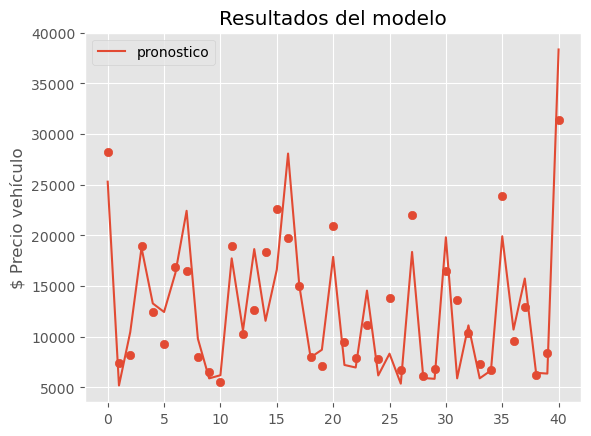

In [14]:
plt.scatter(x=range(0,y_test.shape[0]),y=y_test)
plt.plot(resultados,label='pronostico')
plt.title('Resultados del modelo')
plt.ylabel('$ Precio vehículo')
plt.legend()
plt.show()